# Image Processing Test Case V2.0

## Code by: Joshua Collins, Guy Bowker. Group 1 - RSEP

In this image processing test-case the microstructural grains in an image will be isolated using the 'skikit-image' processing package. 

To test the effectiveness of this code, an average grain size will be estimated. A known value of 24.9 microns was previously calculated using a linear intercept method.

The image used in this test case was obtained by Joshua Collins, PhD student at the University of Manchester, and use of the image was approved by their acedemic supervisor Dr Ed Pickering. 

### 1. Importing Packages

First the required packages and sub-packages much be imported.

In [4]:
import skimage
from skimage import data, io, filters
from skimage.color import rgb2gray
from skimage import exposure
from skimage.filters import sobel
from skimage.morphology import watershed
from scipy import ndimage as ndi
from skimage import measure

import os
import numpy as np
import matplotlib.pyplot as plt
print('done')

done


### 2. Reading the Image

The image to be processed is a dark field optical image of a thermally etched SA-508 Grade 3 steel microstructure.

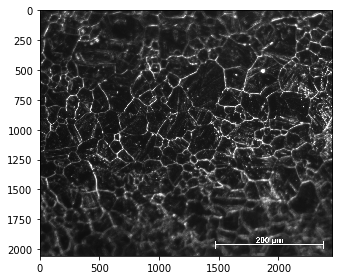

[[50 49 50 ... 41 41 42]
 [49 47 48 ... 40 40 40]
 [52 50 50 ... 40 38 38]
 ...
 [43 43 41 ... 36 36 36]
 [43 42 41 ... 37 37 37]
 [45 44 42 ... 38 37 37]]


In [19]:
grains = io.imread('SA508_Gr3.jpg')

io.imshow(grains)
io.show()
print(grains)

Let's check the image type and shape.

In [7]:
print('The image type is:', grains.dtype, ', and its shape is:', grains.shape)

The image type is: uint8 , and its shape is: (2056, 2452)


This means our image array made up of integers and only has 2 colour channels (i.e. a grayscale image).

### 3. Manipulating the Image

To calculate the sizes of the grains present in the image each grain must first be isolated.

First, let's crop out the out-of-focus areas.

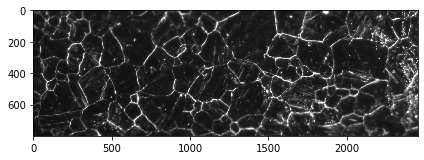

In [8]:
img = grains[500:1300]
io.imshow(img)

Now let us adjust the exposure in the image so that the grain boundaries are easier to distinguish.

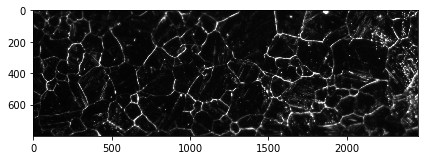

In [9]:
image = exposure.adjust_gamma(img,1.5)
io.imshow(image)

### 4. Segmenting the Image

The image processing technique used here will use a region-based method using a watershed transform to segment each individual grain. 

First, we need to create an elevation map using the Sobel gradient of the image.

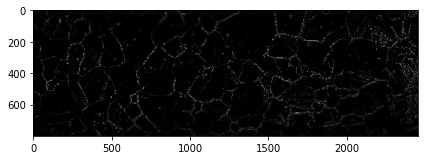

In [10]:
elevation_map = sobel(image)
io.imshow(elevation_map)

Next we will find markers between the background and the grains based on the extreme parts of a histogram of gray values.

/opt/anaconda3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


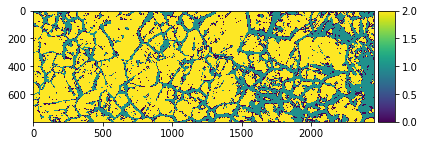

In [11]:
markers = np.zeros_like(image)
markers[image > 20] = 1
markers[image < 15] = 2

io.imshow(markers)

Finally, we use the watershed transform to fill regions of the elevation map starting from the markers determined above.

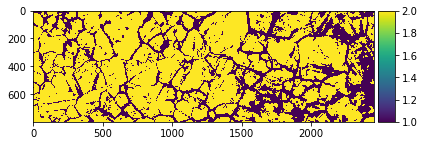

In [12]:
segmentation = watershed(elevation_map, markers)
io.imshow(segmentation)

Now the grains can be segmented and labeled individually.

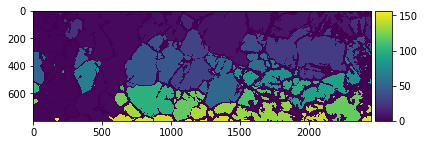

In [30]:
segmentation_n = ndi.binary_fill_holes(segmentation - 1)
labeled_grains, _ = ndi.label(segmentation_n)
io.imshow(labeled_grains)

Here, the image will be returned to greyscale, so that each grain may be assigned a phase number assosiated with a set of materials parameters at a temperature indicative of the volume fraction. This image/numpy array will be saved as a comma seperated value file that can be easily read into a numpy array and re-visualized so that the mesh can be built for FEM:

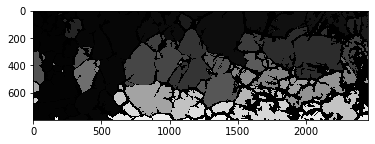

In [31]:
# ------------------------------------------- #
plt.imshow(labeled_grains, cmap=plt.get_cmap("gray"))
np.savetxt('new_img_greyscale.csv', labeled_grains, delimiter=',')
# ------------------------------------------- #

### 5. Measuring Grain Size

From these labeled grains, we can now estimate the average grain size. To do this we will calculate the area of each segmented grain and then assuming the grains are perfect circles we can estimate the average grain diameter.

The area of each segmented grain can be printed in an array as follows:

In [81]:
properties = measure.regionprops(labeled_grains)
[prop.area for prop in properties]

[1176,
 168355,
 3770,
 218657,
 94,
 724,
 50473,
 93530,
 21426,
 31194,
 23014,
 252,
 3191,
 495,
 227,
 6444,
 6298,
 2,
 1,
 9,
 6887,
 424,
 9881,
 38,
 215,
 122,
 523,
 121132,
 40,
 1711,
 66,
 67775,
 53,
 57,
 497,
 110,
 16085,
 195,
 7373,
 574,
 13225,
 201,
 87759,
 284,
 303,
 963,
 804,
 1095,
 7594,
 209,
 13806,
 305,
 61388,
 1121,
 1778,
 11482,
 641,
 290,
 147,
 54,
 267,
 121,
 839,
 28,
 1,
 37,
 1740,
 24283,
 921,
 907,
 244,
 110,
 1,
 144,
 466,
 438,
 7277,
 825,
 674,
 18565,
 2612,
 71,
 258,
 30,
 67,
 168,
 7348,
 138,
 5,
 106,
 37132,
 69,
 1653,
 15,
 573,
 19,
 3284,
 7,
 7280,
 752,
 58083,
 55,
 2771,
 88,
 154,
 71,
 834,
 123,
 74,
 465,
 46,
 10130,
 28,
 1825,
 8,
 841,
 2,
 1650,
 24681,
 32312,
 1586,
 47,
 6335,
 104,
 201,
 896,
 130,
 1003,
 422,
 619,
 4259,
 29200,
 8976,
 191,
 6716,
 1441,
 8458,
 1308,
 2081,
 69,
 1481,
 264,
 5681,
 1058,
 5208,
 5077,
 92,
 3246,
 2789,
 2016,
 166,
 613,
 279,
 272,
 531,
 472,
 60]

With the average area equalling:

In [82]:
av_area = np.mean([prop.area for prop in properties])
print(av_area, 'pixels squared')

9067.528662420382 pixels squared


Assuming a perfect circle, the average grain diameter is:

In [83]:
av_dia = (np.sqrt(av_area / np.pi)) * 2
print(av_dia, 'pixels')

107.44829484925839 pixels


To convert pixels to microns we need to calculate the length of the scale bar in pixels. Let's estimate this by isolating the scalebar from the image and determining its length.

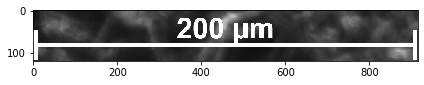

In [84]:
scalebar = grains[1880:2000,1465:2380]
io.imshow(scalebar)

In [85]:
print('The length of the scalebar is', scalebar.shape[1], 'pixels.','Thus each pixel is equal to', 200/scalebar.shape[1], 'microns.')

The length of the scalebar is 915 pixels. Thus each pixel is equal to 0.2185792349726776 microns.


In [86]:
print('Therefore, the average grain size is approximately',av_dia * 200/scalebar.shape[1], 'microns.')

Therefore, the average grain size is approximately 23.485966087269592 microns.


This value is very close to the previously estimated value of 24.9 microns. The small discrepency between these values will most likely be a result of technical assumptions and possibly the loss of grain area during segmentation. 